# Setup Packages

In this section, we will setup the required packages to make sure our environment is ready.

## If Working on Local Environment

***Check README FILE***

## If Working on Colab

If you are running this Notebook on Google Colab, use the following command to download the necessary data files.

In [1]:
!curl "https://drive.usercontent.google.com/download?id={10tkHjBkhzV_RUExS0J1jLfqiabpJfVfI}&confirm=xxx" -o "task1.zip"
import zipfile, os
with zipfile.ZipFile("./task1.zip", 'r') as z:
    z.extractall('.')

os.remove("task1.zip")
print("Zip file unzipped and deleted successfully.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 71530  100 71530    0     0  75323      0 --:--:-- --:--:-- --:--:-- 75294
Zip file unzipped and deleted successfully.


In [2]:
!pip install -e . > /dev/null 2>&1

# Import Packages

In [3]:
from WildfireLogan import assimilation
from WildfireLogan import download
import numpy as np
import torch
import matplotlib.pyplot as plt

In this step, we will import the required Python packages.

# Download Data from Google Drive

In [4]:
download.download_file('1SzfVFHCzEjJ76jQsfQgC7A2ygEozrIeU', 'task1_generated_images.npy')
download.download_file('1tYB_88sNHDqLmS-N-xGA1RWj9jgfn8Dk', 'task2_generated_images.npy')
download.download_file('1iC4lTWN-w5eSVbbC16WDa002AoFg4kQa', "Ferguson_fire_obs.npy")

Download successful, saved to task1_generated_images.npy
Download successful, saved to task2_generated_images.npy
Download successful, saved to Ferguson_fire_obs.npy


# Load Data

In [5]:
task1_images = np.load("task1_generated_images.npy")
task2_images = np.load("task2_generated_images.npy")
satellite_images = np.load("Ferguson_fire_obs.npy")

### Explanation of images:

- `task1_images`: generated images for task 1.
- `task2_images`: generated images for task 2.
- `satellite_images`: satellite image data.

## Plot Images

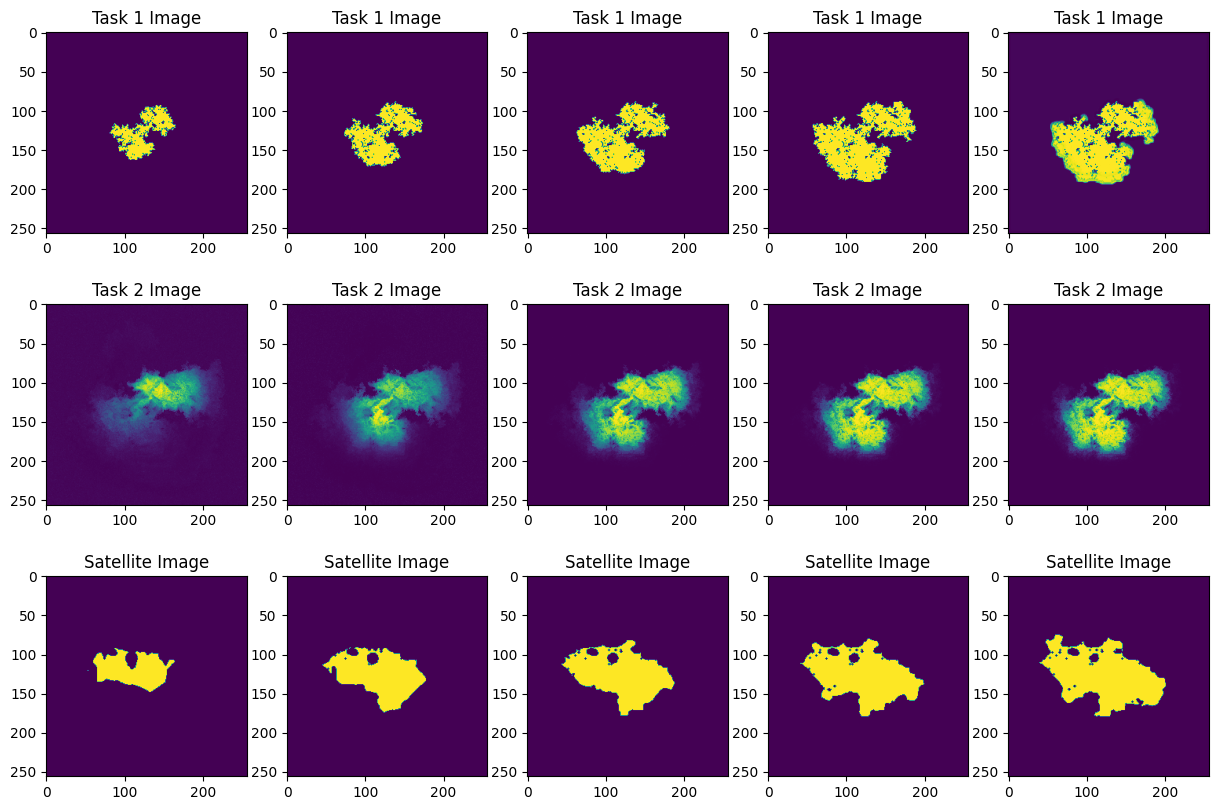

In [6]:
# plot the task 1, task 2 and satellite images, all have 5 images
fig, axs = plt.subplots(3, 5, figsize=(15, 10))
for i in range(5):
    axs[0, i].imshow(task1_images[i])
    axs[0, i].set_title("Task 1 Image")
    axs[1, i].imshow(task2_images[i])
    axs[1, i].set_title("Task 2 Image")
    axs[2, i].imshow(satellite_images[i])
    axs[2, i].set_title("Satellite Image")

### Analysis of the images:

- By observing the prediction images, we can find that the images generated by the background are somewhat different from the real observed satellite images. This discrepancy is evident in both the convLSTM model used in Task 1 and the VAE model used in Task 2.

- Therefore, in order to make our predictions closer to the actual satellite images, we need to assimilate the two datasets.


# Create CAE Model for Data Compression

## Download model parameters from Google Drive

In [7]:
download.download_file('14tS8ZqrRe-0DeTWcmZdUorBHjaGInP6V', 'conv_autoencoder_state_dict.pth')

Download successful, saved to conv_autoencoder_state_dict.pth


## Initialize and load model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
cae = assimilation.ConvAutoencoder().to(device)
cae.load_state_dict(torch.load('conv_autoencoder_state_dict.pth', map_location=device))

<All keys matched successfully>

# Compress and Data

The compressed data will be used in the subsequent assimilation process.

In [10]:
satellite_data_compr = assimilation.encoding(cae, satellite_images)
task1_data_compr = assimilation.encoding(cae, task1_images)
task2_data_compr = assimilation.encoding(cae, task2_images)

In this self encoder model, we compress the high dimensional image data into a 2D latent space. This compression has the following advantages:

1. Dimensionality reduction: the dimensionality of the data is greatly reduced, thus reducing computational complexity and storage requirements.
2. Feature extraction: the main features of the image are retained, enabling the model to effectively learn and represent image information in a low-dimensional space.
3. Visualisation: The two-dimensional potential space facilitates visualisation, helping us to intuitively understand the distribution of data and the performance of the model.

## Plot compressed data

Show the visualisation results of the compressed data. We will show compressed data for Task 1, Task 2 and satellite images.

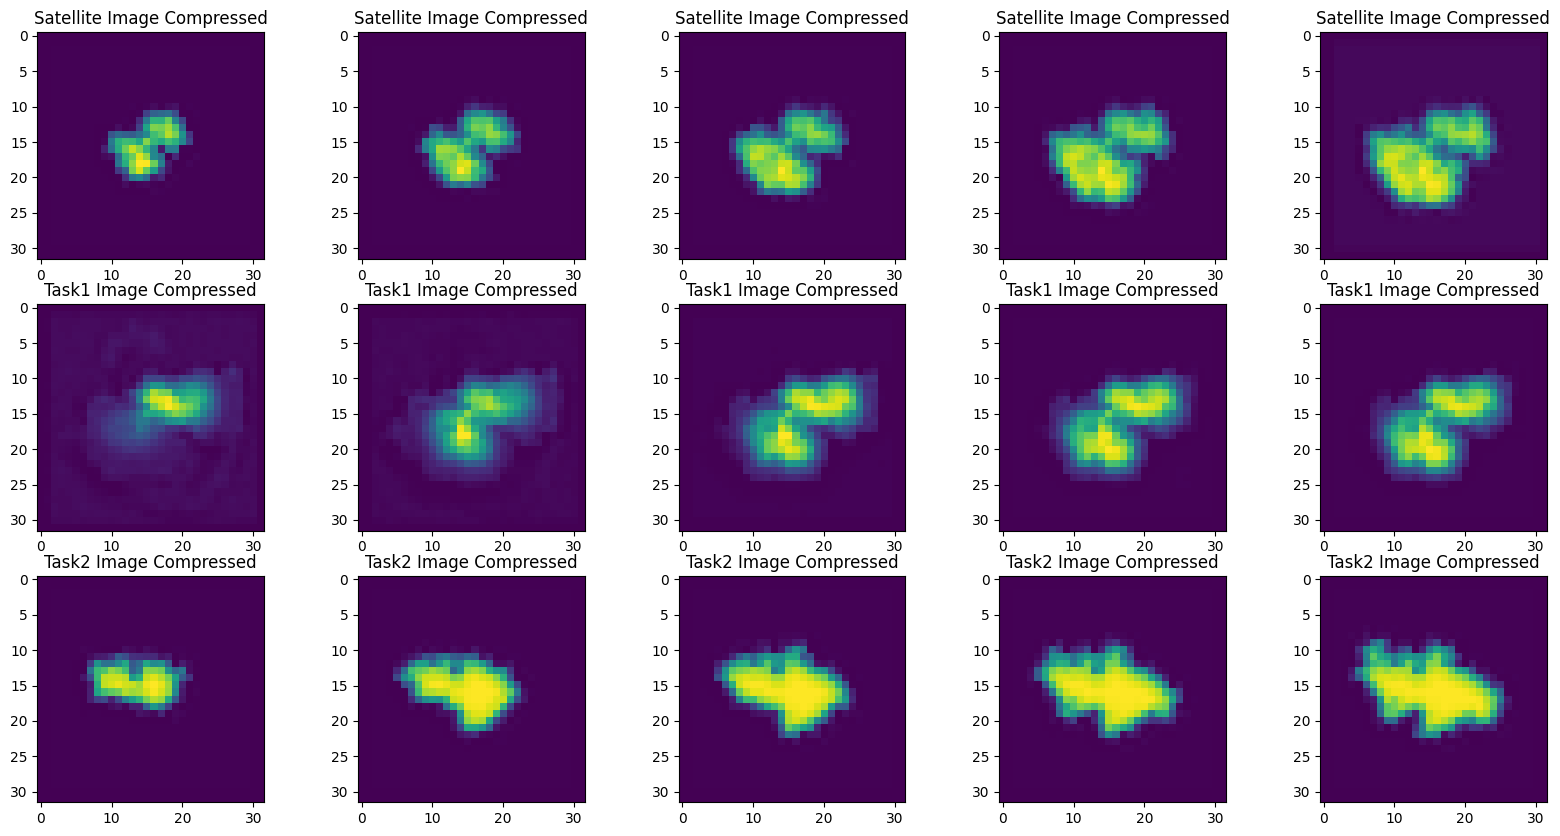

In [11]:
fig, axs = plt.subplots(3, 5, figsize=(20, 10))
for i in range(5):
    axs[0, i].imshow(task1_data_compr[i])
    axs[0, i].set_title('Satellite Image Compressed')
    axs[1, i].imshow(task2_data_compr[i])
    axs[1, i].set_title('Task1 Image Compressed')
    axs[2, i].imshow(satellite_data_compr[i])
    axs[2, i].set_title('Task2 Image Compressed')

These images show the effect of different models (e.g., convLSTM and VAE) in compressing high-dimensional image data into a low-dimensional potential space.

With these compressed images, we can visualise the feature distribution of different types of images:

- Task1 Image Compressed: The patterns in these compressed images are apparent and tightly clustered.
- Task2 Image Compressed: These compressed images show more complex and dispersed patterns that may contain more detail and variation.
- Satellite Image Compressed: shows a compressed satellite image that retains certain features


# Assimilation

## Define Matrixes

In [12]:
R_task1, B_task1, best_mse = assimilation.grid_search(satellite_data_compr, task1_data_compr, assimilation.R_factors, assimilation.B_factors)
R_task2, B_task2, best_mse = assimilation.grid_search(satellite_data_compr, task2_data_compr, assimilation.R_factors, assimilation.B_factors)

In [13]:
I = np.identity(np.square(satellite_data_compr.shape[1]))
H = I
K_task1 = assimilation.KalmanGain(B_task1, H, R_task1)
K_task2 = assimilation.KalmanGain(B_task2, H, R_task2)

## Assimilation for task1 background images

In [14]:
updated_task1_data_recon = assimilation.update_data(task1_data_compr, satellite_data_compr, cae, K_task1, H, task1_images, satellite_images, assimilation.update_prediction, task=1)

Task 1
MSE before DA in latent space: 8.011186599731445
MSE after DA in latent space: 7.328342028362683e-11
MSE before DA in physical space: 0.0736069684661284
MSE after DA in physical space: 0.003956699389914943


## Assimilation for task2 background images

In [15]:
updated_task2_data_recon = assimilation.update_data(task2_data_compr, satellite_data_compr, cae, K_task1, H, task2_images, satellite_images, assimilation.update_prediction, task=2)

Task 2
MSE before DA in latent space: 9.255593299865723
MSE after DA in latent space: 7.626320269285093e-11
MSE before DA in physical space: 0.06613081121536987
MSE after DA in physical space: 0.00395669897346356


### Analysis of Results

- Through the assimilation of data for Task 1 and Task 2, we can observe a significant reduction in the mean squared error (MSE) in both the latent space and the physical space.
- This indicates that the data assimilation method effectively reduces the differences between the predicted images and the real observed satellite images, thereby improving the accuracy of the model's predictions.

# Plot assimilated images

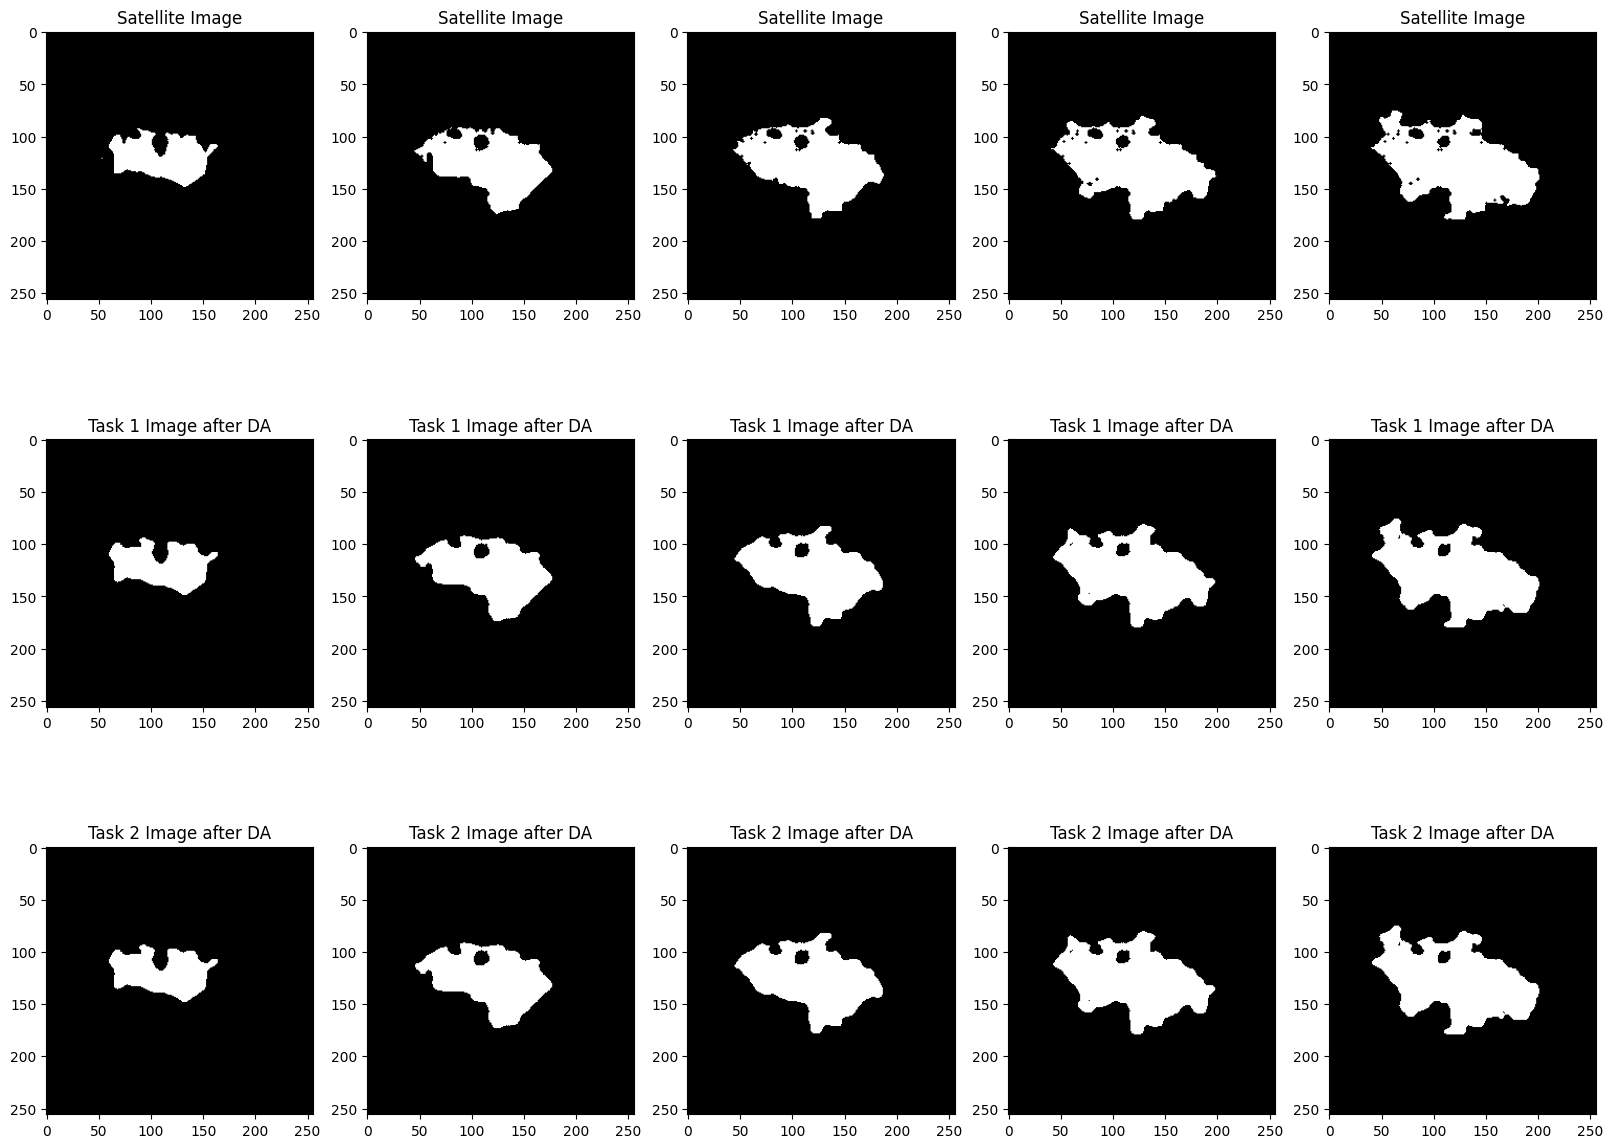

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 5, figsize=(20, 15))
for i in range(5):
    ax[0, i].imshow(np.where(satellite_images[i] >= 0.5, 1, 0), cmap='gray')
    ax[0, i].set_title('Satellite Image')
    ax[1, i].imshow(np.where(updated_task1_data_recon[i] >= 0.5, 1, 0), cmap='gray')
    ax[1, i].set_title('Task 1 Image after DA')
    ax[2, i].imshow(np.where(updated_task2_data_recon[i] >= 0.5, 1, 0), cmap='gray')
    ax[2, i].set_title('Task 2 Image after DA')

## Analysis of Data Assimilation Effect

By comparing the images before and after assimilation, we can observe the following points:

- Improved Similarity:
Regardless of whether it is the Task 1 images or Task 2 images, the similarity to the real satellite images has significantly improved after data assimilation. The white areas in the images align more closely with the shapes and positions of the target areas in the satellite images.

- Detail Preservation:
The assimilated images retain more details, especially around the edges, which helps improve the model's prediction performance.
